# **VibeTune: A Spotify-based Music Recommendation System Using Audio Features and Mood Clustering**

# 1) Data Pre-processing:

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# Load the datasets
spotify_data = pd.read_csv("data.csv", encoding='latin1')
second_data = pd.read_csv("SecondData.csv", encoding='latin1')

# View first few rows
print("Spotify Data Sample:")
print(spotify_data.head())
print("\nSecond Data Sample:")
print(second_data.head())

Spotify Data Sample:
                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0                147  141

##Step 1: Data Preparation

In [5]:
# Clean column names (optional but good practice)
spotify_data.columns = spotify_data.columns.str.strip().str.lower().str.replace(' ', '_')
second_data.columns = second_data.columns.str.strip().str.lower().str.replace(' ', '_')

# Check missing values
print("\nMissing values in spotify_data:")
print(spotify_data.isnull().sum())


print("\nMissing values in second_data:")
print(second_data.isnull().sum())


Missing values in spotify_data:
track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

Missing values in second_data:
songs_&_artist    0
streams           0
daily             2
dtype: int64


##Step 2: Basic Cleaning

In [6]:
# Fill missing numeric fields if any
spotify_data = spotify_data.fillna(0)
second_data = second_data.fillna(0)

# Strip leading/trailing spaces from text columns
spotify_data['track_name'] = spotify_data['track_name'].str.strip()
spotify_data['artist(s)_name'] = spotify_data['artist(s)_name'].str.strip()


second_data['songs_&_artist'] = second_data['songs_&_artist'].str.strip()

# Lowercase all song names for consistency
spotify_data['track_name'] = spotify_data['track_name'].str.lower()
second_data['songs_&_artist'] = second_data['songs_&_artist'].str.lower()

##Step 3: Split Artist and Song (Second Dataset)

In [7]:
# Split 'songs_&_artist' into 'artist' and 'track'
second_data[['artist_name', 'track_name']] = second_data['songs_&_artist'].str.split(' - ', n=1, expand=True)

# Drop the old combined column
second_data.drop('songs_&_artist', axis=1, inplace=True)

# Check sample
print(second_data.head())

      streams      daily    artist_name         track_name
0  4463658617  1619447.0     the weeknd    blinding lights
1  4018102402  1001507.0     ed sheeran       shape of you
2  3588673578  1506961.0  lewis capaldi  someone you loved
3  3544187311  1611374.0   harry styles          as it was
4  3518744128  1337404.0    post malone          sunflower


##Step 4: Normalize Song Names for Merge

Sometimes song names have brackets like "(Explicit Ver.)" or extra spaces — removing them:

In [8]:
import re

# Define function to clean track names safely
def clean_track_name(name):
    if pd.isnull(name):   # <-- check for None or NaN
        return ""
    # Remove anything inside parentheses or brackets
    name = re.sub(r'\(.*?\)', '', name)
    name = re.sub(r'\[.*?\]', '', name)
    # Remove special characters
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name)
    # Lowercase and strip
    return name.strip().lower()

# Apply cleaning
spotify_data['clean_track_name'] = spotify_data['track_name'].apply(clean_track_name)
second_data['clean_track_name'] = second_data['track_name'].apply(clean_track_name)

# Preview
print(spotify_data[['track_name', 'clean_track_name']].head())
print(second_data[['track_name', 'clean_track_name']].head())


                            track_name clean_track_name
0  seven (feat. latto) (explicit ver.)            seven
1                                 lala             lala
2                              vampire          vampire
3                         cruel summer     cruel summer
4                       where she goes   where she goes
          track_name   clean_track_name
0    blinding lights    blinding lights
1       shape of you       shape of you
2  someone you loved  someone you loved
3          as it was          as it was
4          sunflower          sunflower


##Step 5: Merging Data from two datasets

In [9]:
# Check how many songs match by clean name
matched_data = pd.merge(spotify_data, second_data, on='clean_track_name', how='left')

matched_data.head()

# Note:
# streams_x = from spotify_data
# streams_y = from second_data (total streams)

,track_name_x,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams_x,in_apple_playlists,...,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,clean_track_name,streams_y,daily,artist_name,track_name_y
0,seven (feat. latto) (explicit ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,83,31,0,8,4,seven,1.917642e+09,2570770.0,jung kook,seven
1,lala,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,74,7,0,10,4,lala,1.028632e+09,1127056.0,myke towers,lala
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,53,17,0,31,6,vampire,1.118845e+09,1040502.0,olivia rodrigo,vampire
3,cruel summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,72,11,0,11,15,cruel summer,2.481542e+09,2271270.0,taylor swift,cruel summer
4,where she goes,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,80,14,63,11,6,where she goes,7.626024e+08,335228.0,bad bunny,where she goes


# 2) Exploratory Data Analysis:

In [10]:
# Step 1: Basic Descriptive Statistics
print("\nBasic Statistics for Numeric Columns:\n")
print(spotify_data.describe())


Basic Statistics for Numeric Columns:

       artist_count  released_year  released_month  released_day  \
count    953.000000     953.000000      953.000000    953.000000   
mean       1.556139    2018.238195        6.033578     13.930745   
std        0.893044      11.116218        3.566435      9.201949   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2020.000000        3.000000      6.000000   
50%        1.000000    2022.000000        6.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   

       in_spotify_playlists  in_spotify_charts  in_apple_playlists  \
count            953.000000         953.000000          953.000000   
mean            5200.124869          12.009444           67.812172   
std             7897.608990          19.575992           86.441493   
min               31.000000           0.000000            0.000000 

<ipython-input-11-e268ea64bc95>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette='mako')


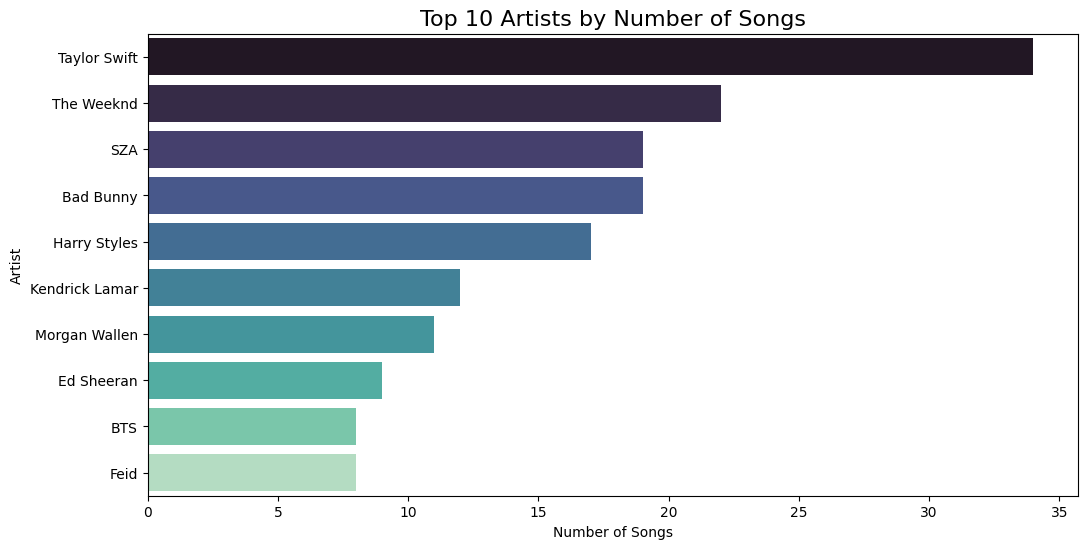

In [11]:
# Step 2: Top Artists by Number of Songs
plt.figure(figsize=(12,6))
top_artists = spotify_data['artist(s)_name'].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index, palette='mako')
plt.title('Top 10 Artists by Number of Songs', fontsize=16)
plt.xlabel('Number of Songs')
plt.ylabel('Artist')
plt.show()

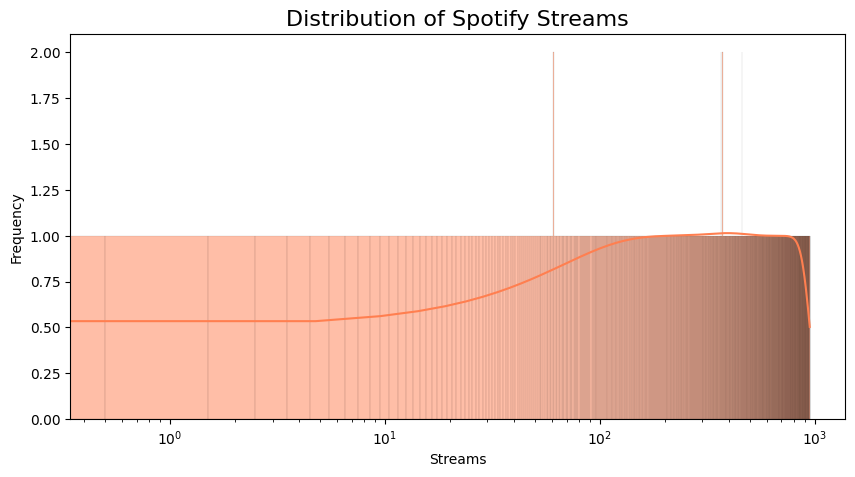

In [12]:
# Step 3: Distribution of Streams
plt.figure(figsize=(10,5))
sns.histplot(spotify_data['streams'], bins=30, kde=True, color='coral')
plt.title('Distribution of Spotify Streams', fontsize=16)
plt.xlabel('Streams')
plt.ylabel('Frequency')
plt.xscale('log')
plt.show()

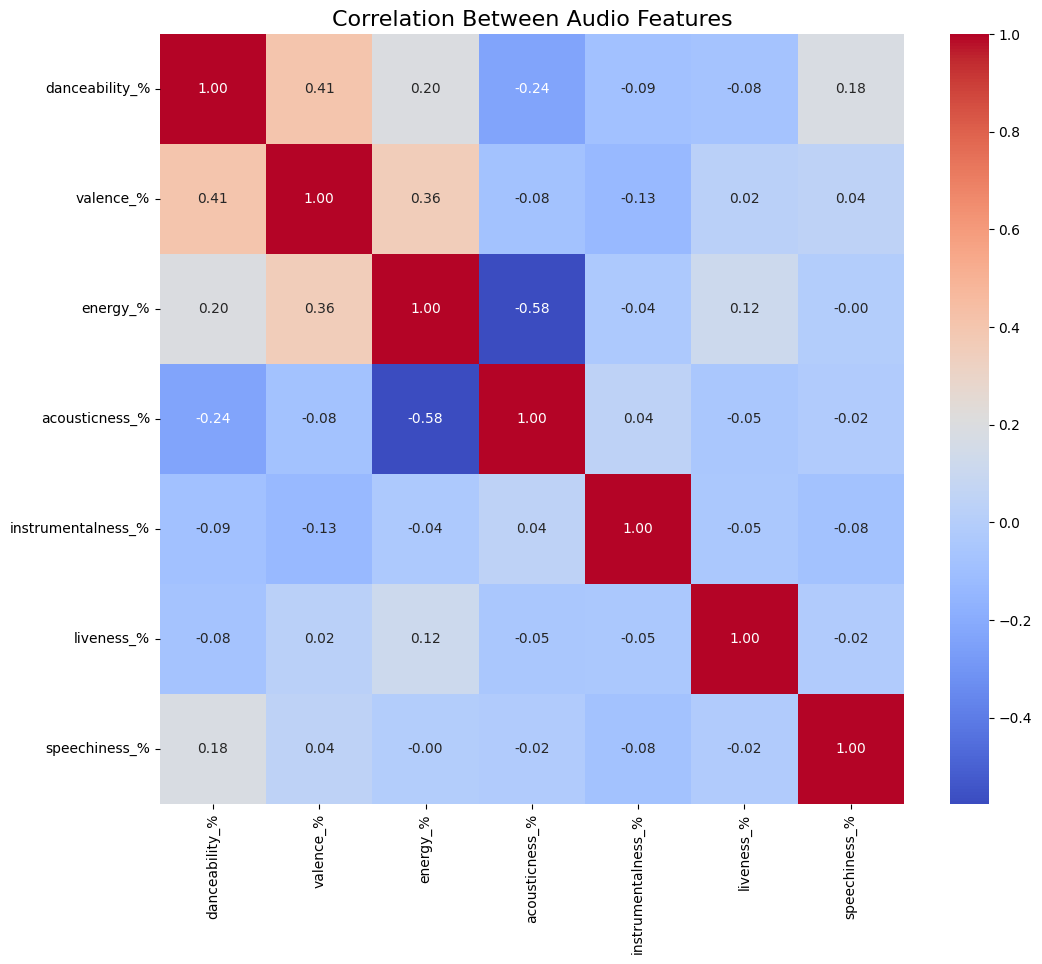

In [13]:
# Step 4: Correlation Heatmap of Audio Features
plt.figure(figsize=(12,10))
audio_features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
correlation = spotify_data[audio_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Audio Features', fontsize=16)
plt.show()

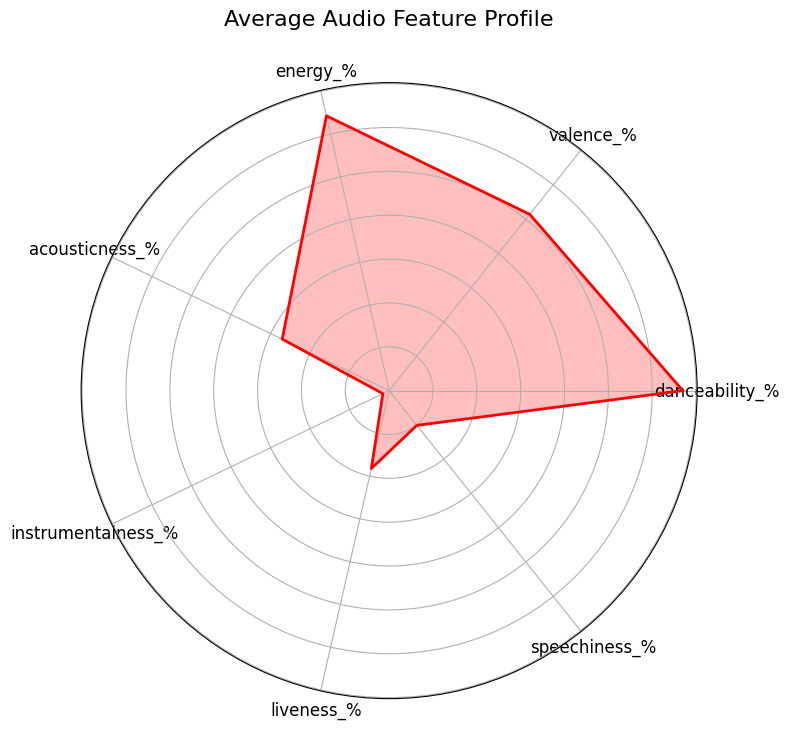

In [14]:
# Step 5: Radar Plot for Average Audio Feature Profile
avg_features = spotify_data[audio_features].mean()
labels = audio_features
values = avg_features.values

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
values = np.concatenate((values, [values[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, color='red', linewidth=2)
ax.fill(angles, values, color='red', alpha=0.25)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
plt.title('Average Audio Feature Profile', size=16, y=1.08)
plt.show()

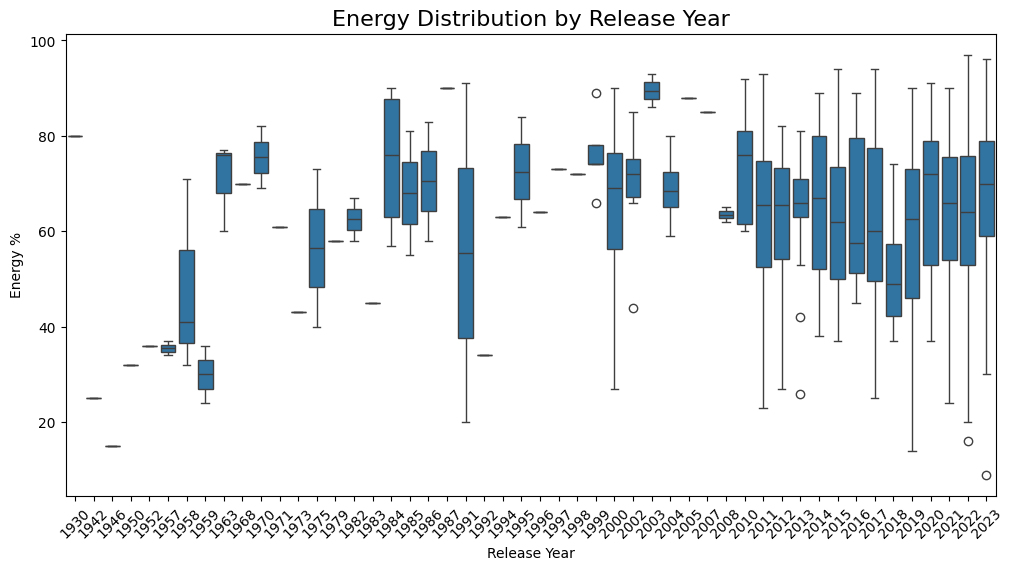

In [15]:
# Step 6: Energy Distribution per Year
if 'released_year' in spotify_data.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='released_year', y='energy_%', data=spotify_data)
    plt.title('Energy Distribution by Release Year', fontsize=16)
    plt.xlabel('Release Year')
    plt.ylabel('Energy %')
    plt.xticks(rotation=45)
    plt.show()

# 3) Recommendation Systems:

##Technique 1: Cosine Similarity-based Recommendation System

This technique implements a content-based music recommendation system using audio features such as danceability, energy, and tempo. It standardizes the features, calculates cosine similarity between songs, and returns the top N most musically similar tracks based on a given input song. The system efficiently matches songs through feature-space proximity, offering recommendations that align in mood and vibe.

In [16]:
# Step 1: Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Step 2: Select features for recommendation
features_for_recommendation = ['danceability_%', 'valence_%', 'energy_%',
                               'acousticness_%', 'instrumentalness_%',
                               'liveness_%', 'speechiness_%', 'bpm']

# Fill missing values
matched_data[features_for_recommendation] = matched_data[features_for_recommendation].fillna(0)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(matched_data[features_for_recommendation])

# Step 3: Calculate Cosine Similarity
cosine_sim_matrix = cosine_similarity(scaled_features)

# Step 4: Prepare song indices for fast lookup
song_indices = pd.Series(matched_data.index, index=matched_data['clean_track_name']).drop_duplicates()

# Step 5: Final Recommendation Function
def recommend_songs(song_name, top_n=5):
    song_name_clean = clean_track_name(song_name)

    if song_name_clean not in song_indices:
        print("\nSorry, the song is not found in the database.")
        return []

    idx = song_indices[song_name_clean]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    song_recommendations = []
    for i, score in sim_scores:
        # Display clean_track_name (or original if you have it)
        rec_song = matched_data.iloc[i]['clean_track_name']
        rec_artist = matched_data.iloc[i]['artist(s)_name']
        song_recommendations.append((rec_song, rec_artist, round(score, 3)))

    print(f"\nTop {top_n} Songs similar to '{song_name}':")
    for rec in song_recommendations:
        print(f"- {rec[0]} by {rec[1]} (Similarity: {rec[2]})")

    return song_recommendations

# Example Usage
recommend_songs("Blinding Lights", top_n=5)


Top 5 Songs similar to 'Blinding Lights':
- wild flower by RM (Similarity: 0.98)
- chemical by Post Malone (Similarity: 0.974)
- unstoppable by Sia (Similarity: 0.968)
- stay by Justin Bieber, The Kid Laroi (Similarity: 0.957)
- stay by Justin Bieber, The Kid Laroi (Similarity: 0.957)


[('wild flower', 'RM', np.float64(0.98)),
 ('chemical', 'Post Malone', np.float64(0.974)),
 ('unstoppable', 'Sia', np.float64(0.968)),
 ('stay', 'Justin Bieber, The Kid Laroi', np.float64(0.957)),
 ('stay', 'Justin Bieber, The Kid Laroi', np.float64(0.957))]

In [25]:
def average_cosine_similarity(song_name, top_n=5):
    song_name_clean = clean_track_name(song_name)

    if song_name_clean not in song_indices:
        print("Song not found.")
        return None

    idx = song_indices[song_name_clean]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude the song itself

    avg_similarity = np.mean([score for _, score in sim_scores])
    return avg_similarity

# Example usage
print(f"Average cosine similarity for 'Blinding Lights': {average_cosine_similarity('Blinding Lights'):.3f}")

Average cosine similarity for 'Blinding Lights': 0.968


<ipython-input-27-9bd7a447841b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sample_songs, y=avg_similarities, palette='viridis')


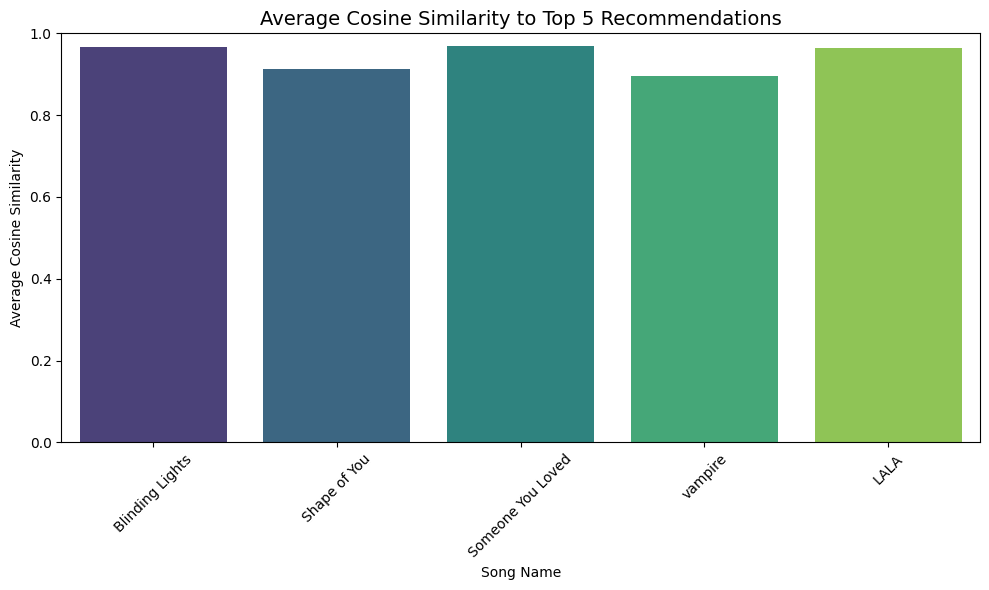

In [27]:
# List of songs to compare
sample_songs = ["Blinding Lights", "Shape of You", "Someone You Loved", "vampire", "LALA"]

# Collect average similarities
avg_similarities = []
for song in sample_songs:
    sim = average_cosine_similarity(song, top_n=5)
    avg_similarities.append(sim)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=sample_songs, y=avg_similarities, palette='viridis')
plt.title('Average Cosine Similarity to Top 5 Recommendations', fontsize=14)
plt.xlabel('Song Name')
plt.ylabel('Average Cosine Similarity')
plt.ylim(0, 1)  # Cosine similarity is between 0 and 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Technique 2: Machine Learning-based Recommendation System

This technique builds a machine learning-based music recommendation system using the K-Nearest Neighbors (KNN) algorithm. It scales audio features such as danceability, energy, and acousticness, then learns the structure of the feature space to suggest the top N nearest songs based on Euclidean distance. The recommendations focus on identifying songs with the most similar musical profiles to the input track.

In [17]:
# Step 1: Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Step 2: Prepare features
features_for_recommendation = ['danceability_%', 'valence_%', 'energy_%',
                               'acousticness_%', 'instrumentalness_%',
                               'liveness_%', 'speechiness_%', 'bpm']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(matched_data[features_for_recommendation])

# Step 3: Build KNN Model
knn_model = NearestNeighbors(n_neighbors=11, metric='euclidean')  # 11 because 1 is itself + 10 neighbors
knn_model.fit(X_scaled)

# Step 4: Song indexing
song_indices = pd.Series(matched_data.index, index=matched_data['clean_track_name']).drop_duplicates()

# Step 5: ML-based Recommendation Function
def recommend_songs_knn(song_name, top_n=5):
    song_name_clean = clean_track_name(song_name)

    if song_name_clean not in song_indices:
        print("\nSorry, the song is not found in the database.")
        return []

    idx = song_indices[song_name_clean]
    song_feature = X_scaled[idx].reshape(1, -1)  # Reshape for prediction
    distances, indices = knn_model.kneighbors(song_feature)

    song_recommendations = []
    for i in range(1, top_n+1):  # start from 1 to skip the song itself
        rec_idx = indices[0][i]
        rec_song = matched_data.iloc[rec_idx]['clean_track_name']
        rec_artist = matched_data.iloc[rec_idx]['artist(s)_name']
        song_recommendations.append((rec_song, rec_artist, round(distances[0][i], 3)))

    print(f"\nTop {top_n} Songs similar to '{song_name}' (using ML - KNN):")
    for rec in song_recommendations:
        print(f"- {rec[0]} by {rec[1]} (Distance: {rec[2]})")

    return song_recommendations

# Example Usage
recommend_songs_knn("Blinding Lights", top_n=5)


Top 5 Songs similar to 'Blinding Lights' (using ML - KNN):
- chemical by Post Malone (Distance: 0.674)
- unstoppable by Sia (Distance: 0.692)
- wild flower by RM (Distance: 0.699)
- stay by Justin Bieber, The Kid Laroi (Distance: 0.831)
- stay by Justin Bieber, The Kid Laroi (Distance: 0.831)


[('chemical', 'Post Malone', np.float64(0.674)),
 ('unstoppable', 'Sia', np.float64(0.692)),
 ('wild flower', 'RM', np.float64(0.699)),
 ('stay', 'Justin Bieber, The Kid Laroi', np.float64(0.831)),
 ('stay', 'Justin Bieber, The Kid Laroi', np.float64(0.831))]

<ipython-input-26-4cea7e94fdb4>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sample_songs, y=avg_distances, palette='magma')


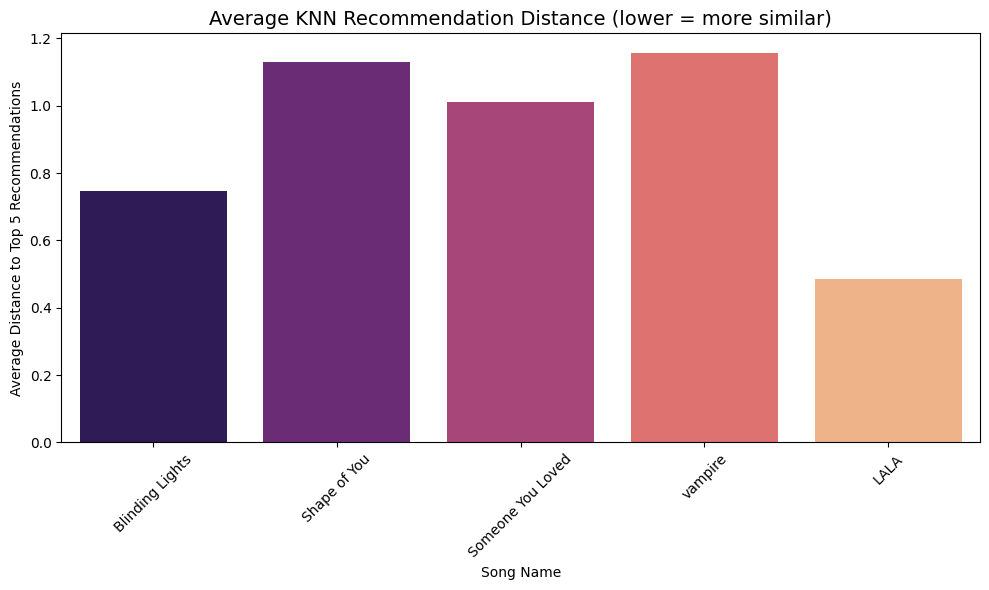

In [26]:
# Sample songs to compare
sample_songs = ["Blinding Lights", "Shape of You", "Someone You Loved", "vampire", "LALA"]

def average_recommendation_distance(song_name, top_n=5):
    song_name_clean = clean_track_name(song_name)

    if song_name_clean not in song_indices:
        print("Song not found.")
        return None

    idx = song_indices[song_name_clean]
    song_feature = X_scaled[idx].reshape(1, -1)
    distances, indices = knn_model.kneighbors(song_feature)

    # Skip the first one (itself)
    avg_distance = np.mean(distances[0][1:top_n+1])
    return avg_distance


# Get average distances
avg_distances = []
for song in sample_songs:
    dist = average_recommendation_distance(song, top_n=5)
    avg_distances.append(dist)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=sample_songs, y=avg_distances, palette='magma')
plt.title('Average KNN Recommendation Distance (lower = more similar)', fontsize=14)
plt.xlabel('Song Name')
plt.ylabel('Average Distance to Top 5 Recommendations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Technique 3: Clustering-based Recommendation System

This technique performs unsupervised clustering of songs using the KMeans algorithm on standardized audio features such as energy, valence, and tempo. It then applies t-SNE for dimensionality reduction to visualize clusters in 2D and assigns intuitive mood-based labels (e.g., “Chill”, “Party”) to each cluster. The result is a visually interpretable map of song moods that enhances playlist curation and mood-based recommendations.

In [18]:
from sklearn.cluster import KMeans

# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)  # You can tune n_clusters!
matched_data['cluster'] = kmeans.fit_predict(X_scaled)

# Song lookup
song_indices = pd.Series(matched_data.index, index=matched_data['clean_track_name']).drop_duplicates()


# Step 1: Group by Cluster
cluster_profile = matched_data.groupby('cluster')[['danceability_%', 'energy_%', 'valence_%',
                                                    'acousticness_%', 'instrumentalness_%',
                                                    'liveness_%', 'speechiness_%', 'bpm']].mean()

# Step 2: Display the mean feature values
print("\nAverage Feature Values per Cluster:")
print(cluster_profile)


Average Feature Values per Cluster:
         danceability_%   energy_%  valence_%  acousticness_%  \
cluster                                                         
0             68.000000  65.742424  50.090909       30.348485   
1             64.353659  75.536585  51.573171       13.756098   
2             73.687500  52.447917  65.802083       60.406250   
3             77.363208  75.877358  73.514151       13.858491   
4             57.055556  62.388889  30.222222       30.666667   
5             69.694915  63.322034  34.932203       14.135593   
6             76.013514  59.054054  54.270270       24.054054   
7             48.621359  38.349515  27.980583       72.883495   
8             49.244444  65.733333  27.922222       16.255556   
9             62.301075  72.709677  70.548387       19.655914   

         instrumentalness_%  liveness_%  speechiness_%         bpm  
cluster                                                             
0                  0.257576   15.590909     

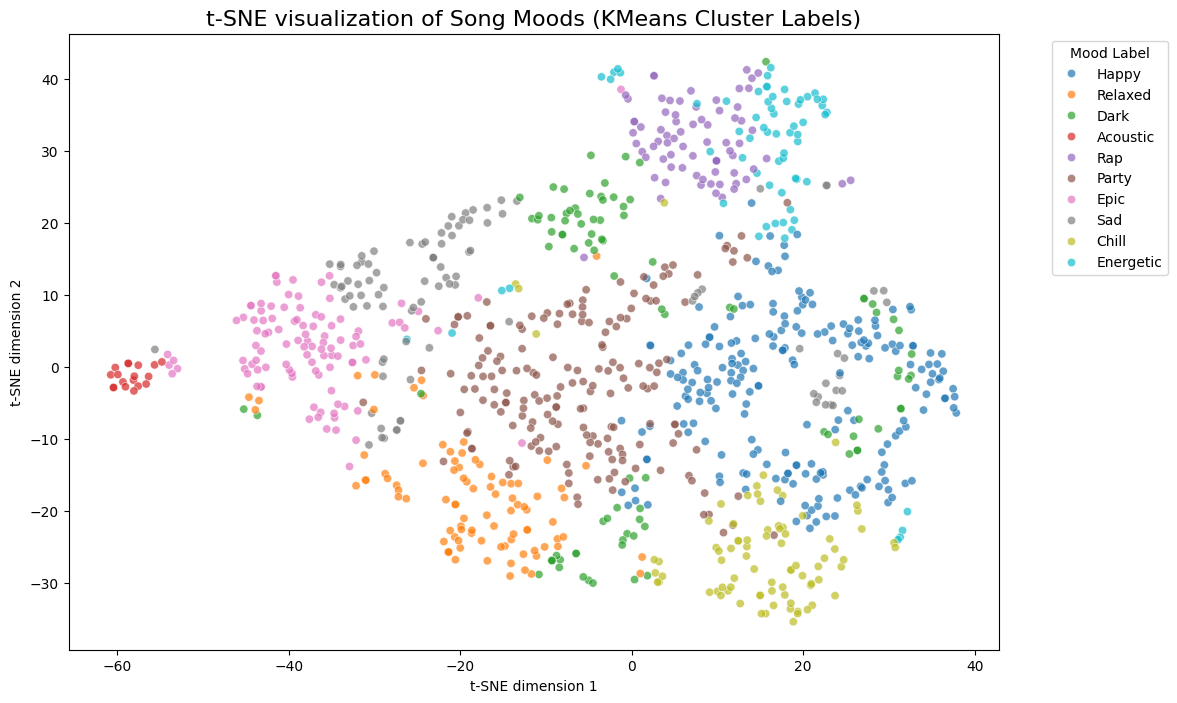

In [19]:
from sklearn.manifold import TSNE

# Step 2: Apply t-SNE for dimensionality reduction
# (t-SNE is good for visualizing clusters in 2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(X_scaled)

# Add t-SNE results to matched_data
matched_data['tsne-2d-one'] = tsne_results[:,0]
matched_data['tsne-2d-two'] = tsne_results[:,1]

# Step 3: Define cluster labels manually (example)
cluster_labels = {
    0: "Energetic",
    1: "Chill",
    2: "Sad",
    3: "Happy",
    4: "Acoustic",
    5: "Party",
    6: "Rap",
    7: "Epic",
    8: "Relaxed",
    9: "Dark"
}

matched_data['cluster_label'] = matched_data['cluster'].map(cluster_labels)

# Step 4: Visualize clusters using t-SNE with Labels
plt.figure(figsize=(12,8))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='cluster_label',
    palette=sns.color_palette("tab10", len(matched_data['cluster_label'].unique())),
    data=matched_data,
    legend="full",
    alpha=0.7
)

plt.title('t-SNE visualization of Song Moods (KMeans Cluster Labels)', fontsize=16)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(title='Mood Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [20]:
# Recommend songs by mood label
def recommend_songs_by_mood(mood_label, top_n=5):
    # Find songs matching the requested mood
    mood_songs = matched_data[matched_data['cluster_label'] == mood_label]

    if mood_songs.empty:
        print(f"\nSorry, no songs found for mood '{mood_label}'.")
        return []

    # Shuffle to get random recommendations from mood cluster
    mood_songs = mood_songs.sample(frac=1, random_state=42)

    song_recommendations = []
    for i in range(min(top_n, len(mood_songs))):
        rec_song = mood_songs.iloc[i]['clean_track_name']
        rec_artist = mood_songs.iloc[i]['artist(s)_name']
        song_recommendations.append((rec_song, rec_artist, mood_label))

    print(f"\nTop {top_n} Songs for Mood '{mood_label}':")
    for rec in song_recommendations:
        print(f"- {rec[0]} by {rec[1]} (Mood: {rec[2]})")

    return song_recommendations

In [21]:
recommend_songs_by_mood("Chill", top_n=5)

recommend_songs_by_mood("Energetic", top_n=7)

recommend_songs_by_mood("Sad", top_n=3)


Top 5 Songs for Mood 'Chill':
- tormenta by Gorillaz, Bad Bunny (Mood: Chill)
- like crazy by Jimin (Mood: Chill)
- double fantasy by The Weeknd, Future (Mood: Chill)
- aint tha by Morgan Wallen (Mood: Chill)
- chorrito pa las animas by Feid (Mood: Chill)

Top 7 Songs for Mood 'Energetic':
- worldwide steppers by Kendrick Lamar (Mood: Energetic)
- givenchy by Duki (Mood: Energetic)
- hey mor by Ozuna, Feid (Mood: Energetic)
- love yourself by Justin Bieber (Mood: Energetic)
- sclass by Stray Kids (Mood: Energetic)
- billie eilish by Armani White (Mood: Energetic)
- red ruby da sleeze by Nicki Minaj (Mood: Energetic)

Top 3 Songs for Mood 'Sad':
- ya no somos ni seremos by Christian Nodal (Mood: Sad)
- thinking out loud by Ed Sheeran (Mood: Sad)
- memories by Maroon 5 (Mood: Sad)


[('ya no somos ni seremos', 'Christian Nodal', 'Sad'),
 ('thinking out loud', 'Ed Sheeran', 'Sad'),
 ('memories', 'Maroon 5', 'Sad')]

In [23]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, matched_data['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.161


In this project, we developed a comprehensive content-based music recommendation system using machine learning techniques. By extracting and engineering relevant audio features such as danceability, energy, and acousticness, we implemented multiple recommendation strategies — including cosine similarity, K-Nearest Neighbors (KNN), and KMeans clustering. Beyond basic similarity matching, we clustered songs into intuitive mood groups like "Chill," "Energetic," and "Sad," enhancing the system's ability to suggest songs aligned not only with musical structure but also emotional vibe.

Through visualizations like t-SNE plots colored by mood labels, we made the underlying patterns in the music data interpretable and accessible. The project demonstrates how unsupervised learning and simple ML models can be combined with feature engineering to create intelligent, scalable, and human-centric music recommendation systems — capable of supporting playlist generation, discovery engines, or personalized music curation.

This project highlights the critical role of data integration in building real-world AI systems: without harmonizing and enriching diverse sources, such intelligent recommendations would not be possible. By combining robust data preparation with machine learning and thoughtful visualization, we created a scalable, interpretable, and mood-driven music recommendation engine — laying a strong foundation for future extensions such as user-personalized playlists or hybrid recommendation systems.